# BERT

**BERT**

In [1]:
import json
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
import numpy as np
import pandas as pd
from scipy.sparse import hstack

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, TimeDistributed, Concatenate, Dropout, MaxPool1D
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

c:\Users\musta\.conda\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Thu Dec  7 23:20:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN X (Pascal)      WDDM  | 00000000:01:00.0 Off |                  N/A |
| 32%   49C    P8              13W / 250W |      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
path = "./general_data.json"

# Parsing the JSON data correctly
parsed_data = []
with open(path, 'r') as file:
    for line in file:
        parsed_data.append(json.loads(line.strip()))

df = pd.DataFrame(parsed_data)
df.head(10)

,ID,user_query,chatgpt_response,hallucination,hallucination_spans
0,1,Produce a list of common words in the English ...,"the, a, and, to, in, that, is, it, of, for, wi...",no,[]
1,2,Provide a few examples of homophones.,1. allowed (permitted) and aloud (out loud)\n2...,yes,[6. hear (to perceive sound) and here (in this...
2,3,Create a chart outlining the world's populatio...,"Unfortunately, as an AI language model, I cann...",yes,[| Year | Population (in billions) |\n|------|...
3,4,Design a shape with 10 vertices (corners).,Here is an example of a shape with 10 vertices...,yes,[```\n /\\n / \ \n /____\\n /\ ...
4,5,Automatically generate a 10 by 10 multiplicati...,"Sure, here is a 10 by 10 multiplication table:...",yes,[Incomplete answer]
5,6,Design a web page that allows a user to sign u...,Header: \n- Logo of the email service provider...,no,[]
6,7,Create the HTML code necessary to display the ...,<h1>Welcome to my website!</h1>\n<p>This is a ...,yes,[Incomplete answer]
7,8,Name a few members of the LGBTQ+ community,1. Ellen DeGeneres\n2. Neil Patrick Harris\n3....,no,[]
8,9,Create a bar chart of the following values\n10...,"I'm sorry, as an AI language model, I don't ha...",yes,"[I'm sorry, as an AI language model, I don't h..."
9,10,Create a design for the given text snippet.\nU...,| U | N | I | T | E | D |\n| W | E |\n| S | T ...,no,[]


In [ ]:
python ./yolov7/train.py --weight ./yolov7.pt --cfg ./yolov7/cfg/training/yolov7.yaml --data ./yolov7/data/BONE.yaml --hyp ./yolov7/data/hyp.scratch.custom.yaml --epochs 50 --device 0

In [5]:
# test_df = df[3000:]
# train_df = df[:3000]

# a = test_df[test_df["hallucination"] == "yes"]
# a
yes_df = df[df["hallucination"] == "yes"].reset_index(drop=True)
no_df = df[df["hallucination"] == "no"].reset_index(drop=True)


yes_df['hallucination_spans'] = yes_df['hallucination_spans'].apply(lambda x: ' '.join(s.replace('\n', '') for s in x))
no_df['hallucination_spans'] = no_df['hallucination_spans'].apply(lambda x: '' if len(x) == 0 else x)
no_df

,ID,user_query,chatgpt_response,hallucination,hallucination_spans
0,1,Produce a list of common words in the English ...,"the, a, and, to, in, that, is, it, of, for, wi...",no,
1,6,Design a web page that allows a user to sign u...,Header: \n- Logo of the email service provider...,no,
2,8,Name a few members of the LGBTQ+ community,1. Ellen DeGeneres\n2. Neil Patrick Harris\n3....,no,
3,10,Create a design for the given text snippet.\nU...,| U | N | I | T | E | D |\n| W | E |\n| S | T ...,no,
4,11,Create a class labeled “NIGHT” which describes...,class NIGHT:\n \n def __init__(self):\n ...,no,
...,...,...,...,...,...
3687,4501,Create a HTML page with a table that has five ...,<!DOCTYPE html>\n<html>\n<head>\n\t<title>Tabl...,no,
3688,4504,Generate an example input to an instruction th...,"""Hey assistant, please write a report on the c...",no,
3689,4505,Do the following equation: 8 + 4 / 2,"The answer is 10. \n\nTo solve the equation, y...",no,
3690,4506,Predict the 2021 wildfire season in California.,"As an AI language model, I do not have the cap...",no,


In [38]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [39]:
# Pre-processing
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...


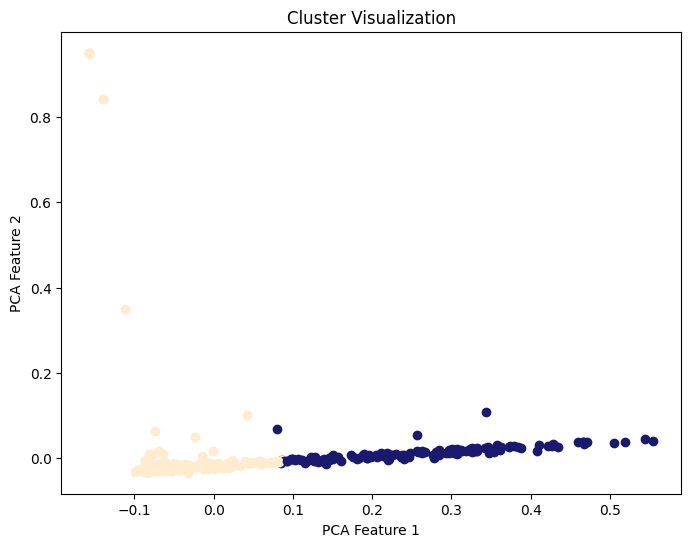

In [97]:
tarin_documents = yes_df['hallucination_spans'][:700]
train_processed_docs = [" ".join([lemmatizer.lemmatize(w) for w in re.sub(r'\W', ' ', doc).split() if w.lower() not in stopwords.words('english')]) for doc in tarin_documents]
test_documents = yes_df['hallucination_spans'][700:]
test_processed_docs = [" ".join([lemmatizer.lemmatize(w) for w in re.sub(r'\W', ' ', doc).split() if w.lower() not in stopwords.words('english')]) for doc in test_documents]

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_processed_docs)
X_test = vectorizer.transform(test_processed_docs)
# Clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)

# Print cluster assignments
# print(kmeans.labels_)

# Dimensionality Reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_train.toarray())

# Generate random colors
num_clusters = 2  # Number of clusters
colors = np.random.choice(list(mcolors.CSS4_COLORS.keys()), num_clusters, replace=False)

# Plotting
plt.figure(figsize=(8, 6))
for i, label in enumerate(kmeans.labels_):
    plt.scatter(reduced_data[i, 0], reduced_data[i, 1], color=colors[label])

plt.title('Cluster Visualization')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

In [80]:
# Predict clusters
new_labels = kmeans.predict(X_test)

# Print new cluster assignments
print(new_labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 0 2 2 2 2 0 2 2 2 2 0 2 2 2 2 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 0 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 0 2 0 2 2 2 0 2 2 2 2 0 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2
 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 2 0 2 2 0 0 0 2 2 2 0 2 2 2 0
 2 0 2 2 0 0 2 0 2 0 2 0 0 0 0 0 0 2 2]


In [99]:
clustered_docs = {i: [] for i in range(kmeans.n_clusters)}
for doc, label in zip(train_processed_docs, kmeans.labels_):
    clustered_docs[label].append(doc)
    
# Manually inspect content of each cluster
for cluster, docs in clustered_docs.items():
    print(f"Cluster {cluster}:")
    for sample_doc in docs[:5]:  # Print first 5 docs for brevity
        print(sample_doc)
    print("\n")

Cluster 0:
sorry AI language model capability create visual chart
sorry AI language model ability create visual chart
AI language model provide sample code linked list data structure different programming language
Sorry AI language model cannot generate sample code using variable without knowing specific programming language would like use
Sorry AI language model access specific table database


Cluster 1:
6 hear perceive sound place 10 place hear perceive sound
Year Population billion 2000 6 126 2001 6 202 2002 6 28 2003 6 357 2004 6 435 2005 6 514 2006 6 593 2007 6 673 2008 6 754 2009 6 835 2010 6 917 2011 7 001 2012 7 086 2013 7 172 2014 7 259 2015 7 347
____ ____ ____ ____ shape decagon polygon 10 side 10 vertex five pair parallel side five angle 144 degree shape made two pentagon overlapping
Incomplete answer
Incomplete answer




In [83]:
clustered_docs

{0: ['sorry AI language model capability create visual chart',
  'sorry AI language model ability create visual chart',
  'AI language model provide sample code linked list data structure different programming language',
  'Sorry AI language model cannot generate sample code using variable without knowing specific programming language would like use',
  'Sorry AI language model access specific table database',
  'cannot create program without input problem statement sorry AI language model cannot create program without input problem statement',
  'sorry AI language model cannot provide interface would allow test use interactive web component like calculator',
  'authorized provide script deleting user Unfortunately AI language model authorized provide script deleting user',
  'AI language model cannot see given Python function',
  'AI language model ability write code',
  'Sorry AI language model cannot generate output without specific input requirement Please provide detail specificat

**Hallucination clustering Final**

Precproecssing with lemmatization method

In [130]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# Example preprocessing function
def preprocess(document, remove_incomplete_label=False):
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in re.sub(r'\W', ' ', document).lower().split()]
    if remove_incomplete_label:
        tokens = [word for word in tokens if word not in ["incomplete", "incomplete_answer"]]
    return " ".join(tokens)

# Apply preprocessing
train_processed_docs = [preprocess(doc) for doc in yes_df["hallucination_spans"]]

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_processed_docs)
X_test = vectorizer.transform(test_processed_docs)
# Clustering
# kmeans = KMeans(n_clusters=7)
# kmeans.fit(X_train)

# Print cluster assignments
# print(kmeans.labels_)

# Dimensionality Reduction
# pca = PCA(n_components=3)
# reduced_data = pca.fit_transform(X_train.toarray())

# # Generate random colors
# num_clusters = 7  # Number of clusters
# colors = np.random.choice(list(mcolors.CSS4_COLORS.keys()), num_clusters, replace=False)

# # Plotting
# plt.figure(figsize=(8, 6))
# for i, label in enumerate(kmeans.labels_):
#     plt.scatter(reduced_data[i, 0], reduced_data[i, 1], color=colors[label])

# plt.title('Cluster Visualization')
# plt.xlabel('PCA Feature 1')
# plt.ylabel('PCA Feature 2')
# plt.show()

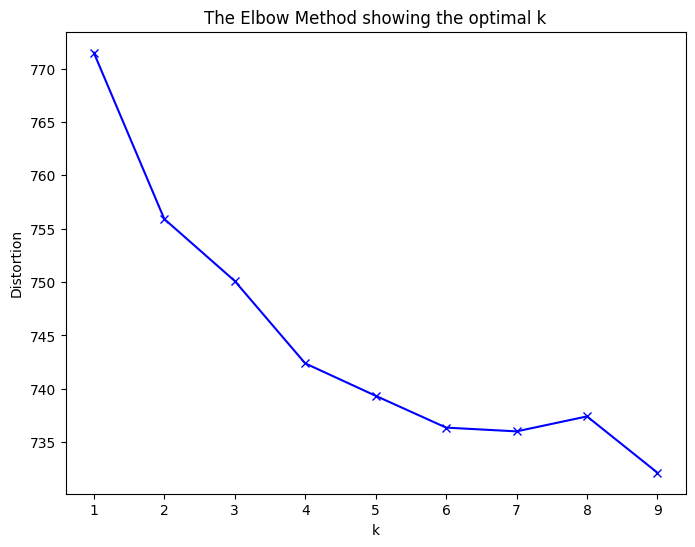

In [132]:
# Assuming you have your feature matrix X
distortions = []
K = range(1,10)  # Example range, adjust based on your data
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method plot you've provided shows the distortion (sum of squared distances of samples to their closest cluster center) for different values of k (number of clusters). Ideally, you're looking for a point on the graph where the rate of decrease in distortion sharply changes, which would indicate a good balance between the number of clusters and the fit of the model.

From the plot, it appears that there's a noticeable elbow at k=3. This suggests that after three clusters, the decrease in distortion begins to slow down, indicating that additional clusters do not contribute significantly to explaining the variance in the data.

So, based on this plot, you might consider k=3 as a suitable choice for the number of clusters in your dataset. Beyond k=3, the improvements in distortion are less pronounced, suggesting diminishing returns in cluster quality with the addition of more clusters.

However, it's also important to note that the elbow method is somewhat subjective, and the choice of k should also be informed by domain knowledge and the interpretability of the clusters. If k=3 makes sense with respect to what you know about your data and your goals for clustering, it's a reasonable choice. If you're expecting more nuanced distinctions in your data or if the clusters at k=3 are not meaningful, you might experiment with other values of k, even if they don't show a strong elbow.

In [134]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

KMeans(n_clusters=3)

In [135]:
clustered_docs = {i: [] for i in range(kmeans.n_clusters)}
for doc, label in zip(train_processed_docs, kmeans.labels_):
    clustered_docs[label].append(doc)
    
# Manually inspect content of each cluster
for cluster, docs in clustered_docs.items():
    print(f"Cluster {cluster}:")
    for sample_doc in docs[:5]:  # Print first 5 docs for brevity
        print(sample_doc)
    print("\n")

Cluster 0:
nogueira r cho k 2019 incorporating adversarial and uncertainty technique into deep learning for molecule generation journal of chemical information and modeling 59 10 4379 4389 doi 10 1021 ac jcim 9b00626 this article present a study on the use of gpt model to generate novel molecule with the incorporation of adversarial and uncertainty technique to improve the quality and diversity of generated molecule the author demonstrate the effectiveness of their approach through a comparison with other state of the art method and analyze the generated molecule in term of their chemical property and similarity to known drug the study provides evidence for the potential of gpt model in the field of drug discovery and show the importance of incorporating additional technique to improve their performance nogueira r cho k 2019 incorporating adversarial and uncertainty technique into deep learning for molecule generation journal of chemical information and modeling 59 10 4379 4389 doi 10 

In [136]:
gpt_response = df['chatgpt_response'][4506]
processed_gpt_response = preprocess(gpt_response)

In [137]:
X_gpt = vectorizer.transform([processed_gpt_response])
gpt_cluster = kmeans.predict(X_gpt)
gpt_cluster

array([0])

In [141]:
hallucination_label = {0: "Wrong Answer",
                       1: "AI limitation",
                       2: "Incomplete Answer"}

for i, k in hallucination_label.items():
    if gpt_cluster[0] == i:
        print("The input consists '{}' type of Hallucination.".format(k))

The input consists 'Wrong Answer' type of Hallucination.


In [6]:
test_df = df[3000:]
train_df = df[:3000]

yes_df = train_df[df["hallucination"] == "yes"].reset_index(drop=True)
no_df = train_df[df["hallucination"] == "no"].reset_index(drop=True)


yes_df['hallucination_spans'] = yes_df['hallucination_spans'].apply(lambda x: ' '.join(s.replace('\n', '') for s in x))
no_df['hallucination_spans'] = no_df['hallucination_spans'].apply(lambda x: '' if len(x) == 0 else x)
no_df


train_no_ratio = round(no_df.shape[0]*0.8)
# train_df = no_df[:train_no_ratio]
# valid_df = no_df[train_no_ratio:]
train_no_df = no_df[:train_no_ratio]
valid_no_df = no_df[train_no_ratio:]

train_yes_ratio = round(yes_df.shape[0] * 0.8)
train_yes_df = yes_df[:train_yes_ratio]
valid_yes_df = yes_df[train_yes_ratio:]

train_df = pd.concat([train_yes_df, train_no_df])
valid_df = pd.concat([valid_yes_df, valid_no_df])

print(train_df.shape)
print(valid_df.shape)

(2400, 5)
(600, 5)


C:\Users\musta\AppData\Local\Temp\ipykernel_5792\2676655213.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  yes_df = train_df[df["hallucination"] == "yes"].reset_index(drop=True)
C:\Users\musta\AppData\Local\Temp\ipykernel_5792\2676655213.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_df = train_df[df["hallucination"] == "no"].reset_index(drop=True)


**Loading the BERT model and Tokenizer**

In [10]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

**Encoding & Tokenizing**

In [11]:
# Define maximum sequence length for BERT input
max_length = 128

def encoding(df, max_length):
    # Tokenize and encode the User Query
    encoded_query = tokenizer.batch_encode_plus(
        df['user_query'],
        add_special_tokens=True,  # '[CLS]' token will be added automatically
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

    # Tokenize and encode the chatgpt_responses
    encoded_responses = tokenizer.batch_encode_plus(
        df['chatgpt_response'],
        add_special_tokens=True,  # '[CLS]' token will be added automatically
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encoded_query, encoded_responses

def id_mask(encoded_query, encoded_responses):
    query_input_ids = encoded_query['input_ids']
    query_attention_masks = encoded_query['attention_mask']

    responses_input_ids = encoded_responses['input_ids']
    response_attention_masks = encoded_responses['attention_mask']

    return query_input_ids, query_attention_masks, responses_input_ids, response_attention_masks

**Binary Class Labels**

In [12]:
def class_label(df):
    # Prepare binary classification labels
    df['hallucination_Labels'] = np.array([1 if sample == "yes" else 0 for sample in df['hallucination']])
    binary_labels = df['hallucination_Labels']
    binary_labels_tensor = tf.keras.utils.to_categorical(binary_labels, num_classes=2, dtype='int32')

    return binary_labels_tensor

**BIO taggings**

'B' = Beginning

'I' = Inside

'O' = Outside

In [31]:
def create_bio_tags(batch_responses_input_ids, hallucination_spans_list, tokenizer, max_length):
    batch_bio_tags = []

    for response_input_ids, hallucination_spans in zip(batch_responses_input_ids, hallucination_spans_list):
        # Convert single response input IDs to tokens
        tokens = tokenizer.convert_ids_to_tokens(response_input_ids)

        # Initialize BIO tags as 'O'
        bio_tags = ['O'] * len(tokens)

        # Check for 'Incomplete answer'
        for span in hallucination_spans:
            if span.split(" ")[0].lower == "incomplete":
                bio_tags = ['INC'] * len(tokens)
        else:
            for span in hallucination_spans:
                if span:
                    span_tokens = tokenizer.tokenize(span)
                    start = -1
                    for i in range(len(tokens) - len(span_tokens)):
                        if tokens[i:i + len(span_tokens)] == span_tokens:
                            start = i
                            break
                    if start != -1:
                        bio_tags[start] = 'B'
                        for i in range(1, len(span_tokens)):
                            bio_tags[start + i] = 'I'

        # Truncate or pad BIO tags to fit max_length
        bio_tags = bio_tags[:max_length]
        bio_tags += ['O'] * (max_length - len(bio_tags))

        # Map BIO tags to indices (B:1, I:2, O:0, INC:3)
        bio_tag_indices = {'B': 1, 'I': 2, 'O': 0, 'INC': 3}
        bio_tags = [bio_tag_indices.get(tag, 0) for tag in bio_tags]

        batch_bio_tags.append(bio_tags)

    return batch_bio_tags

In [13]:
# Encodings
train_encoded_query, train_encoded_responses = encoding(train_df, max_length)
valid_encoded_query, valid_encoded_responses = encoding(valid_df, max_length)
test_encoded_query, test_encoded_responses = encoding(test_df, max_length)

In [14]:
# Input IDs and Attention Mask
train_query_input_ids, train_query_attention_masks, train_responses_input_ids, train_response_attention_masks = id_mask(train_encoded_query, train_encoded_responses)
valid_query_input_ids, valid_query_attention_masks, valid_responses_input_ids, valid_response_attention_masks = id_mask(valid_encoded_query, valid_encoded_responses)
test_query_input_ids, test_query_attention_masks, test_responses_input_ids, test_response_attention_masks = id_mask(test_encoded_query, test_encoded_responses)

In [15]:
# Class Labelling Tensors
train_binary_labels_tensor = class_label(train_df)
valid_binary_labels_tensor = class_label(valid_df)
test_binary_labels_tensor = class_label(test_df)

C:\Users\musta\AppData\Local\Temp\ipykernel_5792\1675740569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hallucination_Labels'] = np.array([1 if sample == "yes" else 0 for sample in df['hallucination']])


**BIO tensors**

In [32]:
def BIO_tensor(responses_input_ids):
    # Generate BIO tags for the batch of responses
    bio_tags_batch = create_bio_tags(responses_input_ids.numpy(), df['hallucination_spans'].tolist(), tokenizer, max_length)

    # Convert to TensorFlow tensor and apply one-hot encoding
    bio_tags_tensor = tf.keras.utils.to_categorical(bio_tags_batch, num_classes=4, dtype='int64')  # Adjust num_classes if needed

    return bio_tags_tensor

In [33]:
# BIO tensors
train_bio_tags_tensor = BIO_tensor(train_responses_input_ids)
valid_bio_tags_tensor = BIO_tensor(valid_responses_input_ids)
# test_bio_tags_tensor = BIO_tensor(test_responses_input_ids)

**Model Architecture design**

(Joint Multi Input Model)

In [16]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LogisticRegression
import keras

In [17]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
    #     print("Shape of y: ",type(y))
    #     print("Shape of y_pred: ",type(y_pred))
    
        actual_labels = y[0] if isinstance(y, tuple) else y
        
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(actual_labels, y_pred)
        # student_loss = self.student_loss_fn(y, y_pred)
        
        

        distillation_loss = self.distillation_loss_fn(
            keras.activations.softmax(teacher_pred / self.temperature, axis=1),
            keras.activations.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

In [18]:
tf.keras.backend.clear_session()    # Clear Session if there any active session exists.

# Define model inputs for queries and responses
query_input_ids = Input(shape=(max_length,), dtype='int32', name='query_input_ids')
query_attention_mask = Input(shape=(max_length,), dtype='int32', name='query_attention_mask')

response_input_ids = Input(shape=(max_length,), dtype='int32', name='response_input_ids')
response_attention_mask = Input(shape=(max_length,), dtype='int32', name='response_attention_mask')

# BERT embeddings for queries and responses
query_bert_output = bert_model(query_input_ids, attention_mask=query_attention_mask)[0]
response_bert_output = bert_model(response_input_ids, attention_mask=response_attention_mask)[0]

# Process each stream with additional layers
query_processed = GlobalAveragePooling1D()(query_bert_output)
response_processed = GlobalAveragePooling1D()(response_bert_output)


# Combine processed outputs
combined_output = Concatenate()([query_processed, response_processed])

# Create the teacher
teacher_classification_dense_1 = Dense(256, activation='relu', name='Class_Dense_Layer_1')(combined_output)
teacher_classification_dropout = Dropout(0.6, name="DropOUT_Class")(teacher_classification_dense_1)
teacher_classification_dense_2 = Dense(16, activation='relu', name='Class_Dense_Layer_2')(teacher_classification_dropout)
teacher_classification_output = Dense(2, activation='sigmoid')(teacher_classification_dense_2)



In [19]:
# Define the ModelCheckpoint callback
checkpoint_path = "./teacher_model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # 'min' means save the model when the monitored quantity (val_loss) has stopped decreasing
    verbose=1  # 1: display messages, 0: silent
)

# Define a custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        # self.f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        self.f1_score.assign(2 * tf.divide(tf.multiply(precision, recall), tf.add(precision, recall) + tf.keras.backend.epsilon()))
        return self.f1_score

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0.0)

# Build the model
teacher_model = Model(
    inputs=[query_input_ids, query_attention_mask, response_input_ids, response_attention_mask],
    outputs=[teacher_classification_output],
    name="Teacher_Model"
)
teacher_model.compile(optimizer=SGD(learning_rate=0.0001), 
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=[F1Score()],
                    )

# Model summary
teacher_model.summary()

Model: "Teacher_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 query_input_ids (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 query_attention_mask (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 response_input_ids (InputLayer  [(None, 128)]       0           []                               


 )                                                                                                
                                                                                                  
 response_attention_mask (Input  [(None, 128)]       0           []                               
 Layer)                                                                                           
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['query_input_ids[0][0]',        
                                thPoolingAndCrossAt               'query_attention_mask[0][0]',   
                                tentions(last_hidde               'response_input_ids[0][0]',     
                                n_state=(None, 128,               'response_attention_mask[0][0]']
                                 768),                                                            
          

In [20]:
teacher_history = teacher_model.fit([train_encoded_query['input_ids'], train_encoded_query['attention_mask'], 
     train_encoded_responses['input_ids'], train_encoded_responses['attention_mask']],
    [train_binary_labels_tensor],
    batch_size=16,
    epochs=100,
    validation_data = ([valid_encoded_query['input_ids'], valid_encoded_query['attention_mask'], 
     valid_encoded_responses['input_ids'], valid_encoded_responses['attention_mask']],
    [valid_binary_labels_tensor],),
    callbacks = [checkpoint_callback]
    )

Epoch 1/100


c:\Users\musta\.conda\envs\tf_gpu\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


150/150 [==============================] - ETA: 0s - loss: 0.5553 - f1_score: 0.7697

c:\Users\musta\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 0.49376, saving model to .\teacher_model_checkpoint.h5
150/150 [==============================] - 105s 596ms/step - loss: 0.5553 - f1_score: 0.7697 - val_loss: 0.4938 - val_f1_score: 0.8217
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.5256 - f1_score: 0.7971
Epoch 2: val_loss improved from 0.49376 to 0.47904, saving model to .\teacher_model_checkpoint.h5
150/150 [==============================] - 91s 607ms/step - loss: 0.5256 - f1_score: 0.7971 - val_loss: 0.4790 - val_f1_score: 0.8217
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.5142 - f1_score: 0.8103
Epoch 3: val_loss improved from 0.47904 to 0.47341, saving model to .\teacher_model_checkpoint.h5
150/150 [==============================] - 92s 611ms/step - loss: 0.5142 - f1_score: 0.8103 - val_loss: 0.4734 - val_f1_score: 0.8217
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 0.4986 - f1_score: 0.8155
Epoch 4: val_lo

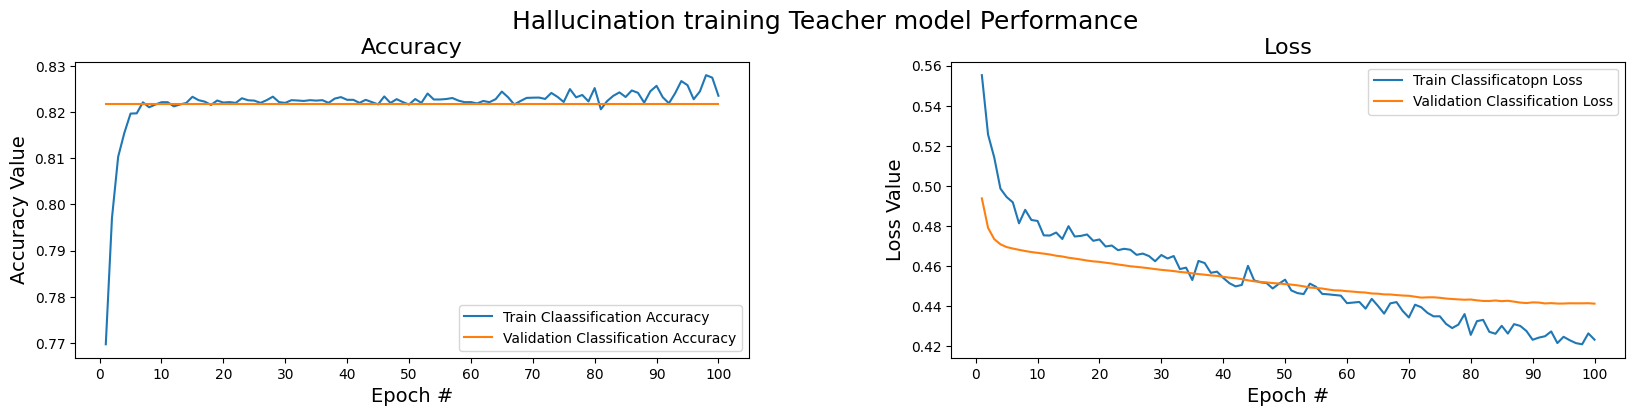

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Hallucination training Teacher model Performance', fontsize=18)
f.subplots_adjust(top=0.85, wspace=0.3)

EPOCHS = 100

epoch_list = list(range(1,EPOCHS+1))

ax1.plot(epoch_list, teacher_history.history['f1_score'], label='Train Claassification Accuracy')
ax1.plot(epoch_list, teacher_history.history['val_f1_score'], label='Validation Classification Accuracy')

ax1.set_xticks(np.arange(0, EPOCHS+1, 10))
ax1.set_ylabel('Accuracy Value', fontsize=14)
ax1.set_xlabel('Epoch #', fontsize=14)
ax1.set_title('Accuracy', fontsize=16)
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, teacher_history.history['loss'], label='Train Classificatopn Loss')
ax2.plot(epoch_list, teacher_history.history['val_loss'], label='Validation Classification Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 10))
ax2.set_ylabel('Loss Value', fontsize=14)
ax2.set_xlabel('Epoch #', fontsize=14)
ax2.set_title('Loss', fontsize=16)
l2 = ax2.legend(loc="best")

In [24]:
teacher_model.evaluate([test_encoded_query['input_ids'], test_encoded_query['attention_mask'], 
     test_encoded_responses['input_ids'], test_encoded_responses['attention_mask']],
    [test_binary_labels_tensor],)

48/48 [==============================] - 15s 304ms/step - loss: 0.4727 - f1_score: 0.8141


[0.4727369248867035, 0.8140535950660706]

In [25]:
# Create Student
student_classification_dense_1 = Dense(16, activation='relu', name='Class_Dense_Layer_1')(combined_output)
student_classification_dropout = Dropout(0.6, name="DropOUT_Class")(student_classification_dense_1)
student_classification_dense_2 = Dense(16, activation='relu', name='Class_Dense_Layer_2')(student_classification_dropout)
student_classification_output = Dense(2, activation='sigmoid')(student_classification_dense_2)

# Build the model
student_model = Model(
    inputs=[query_input_ids, query_attention_mask, response_input_ids, response_attention_mask],
    outputs=[student_classification_output],
    name="Student_Model"
)


# Clone student for later comparison
student_scratch = keras.models.clone_model(student_model)

In [33]:
# Define the ModelCheckpoint callback
checkpoint_path = "./distiler_model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # 'min' means save the model when the monitored quantity (val_loss) has stopped decreasing
    verbose=1  # 1: display messages, 0: silent
)

# Define a custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        # self.f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        self.f1_score.assign(2 * tf.divide(tf.multiply(precision, recall), tf.add(precision, recall) + tf.keras.backend.epsilon()))
        return self.f1_score

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0.0)

# Initialize and compile distiller
distiller_model = Distiller(student=student_model, teacher=teacher_model)
distiller_model.compile(
    optimizer=SGD(learning_rate=0.0001),
    metrics=[F1Score()],
    student_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Model summary
# distiller_model.summary()

In [34]:
# Distill teacher to student
distiller_model.fit([train_encoded_query['input_ids'], train_encoded_query['attention_mask'], 
     train_encoded_responses['input_ids'], train_encoded_responses['attention_mask']],
    [train_binary_labels_tensor],
    batch_size=8,
    epochs=100,
    validation_data = ([valid_encoded_query['input_ids'], valid_encoded_query['attention_mask'], 
     valid_encoded_responses['input_ids'], valid_encoded_responses['attention_mask']],
    [valid_binary_labels_tensor],),
    callbacks=[checkpoint_callback])

# Evaluate student on test dataset
distiller_model.evaluate([test_encoded_query['input_ids'], test_encoded_query['attention_mask'], 
     test_encoded_responses['input_ids'], test_encoded_responses['attention_mask']],
    [test_binary_labels_tensor])

Epoch 1/100


c:\Users\musta\.conda\envs\tf_gpu\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


300/300 [==============================] - ETA: 0s - f1_score: 0.8225

c:\Users\musta\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


300/300 [==============================] - 212s 609ms/step - f1_score: 0.8225 - val_f1_score: 0.8217
Epoch 2/100
300/300 [==============================] - 181s 604ms/step - f1_score: 0.8225 - val_f1_score: 0.8217
Epoch 3/100
300/300 [==============================] - 181s 602ms/step - f1_score: 0.8225 - val_f1_score: 0.8217
Epoch 4/100
300/300 [==============================] - 179s 596ms/step - f1_score: 0.8225 - val_f1_score: 0.8217
Epoch 5/100
300/300 [==============================] - 179s 599ms/step - f1_score: 0.8225 - val_f1_score: 0.8217
Epoch 6/100
300/300 [==============================] - 179s 598ms/step - f1_score: 0.8225 - val_f1_score: 0.8217
Epoch 7/100
300/300 [==============================] - 179s 596ms/step - f1_score: 0.8225 - val_f1_score: 0.8217
Epoch 8/100
300/300 [==============================] - 179s 597ms/step - f1_score: 0.8225 - val_f1_score: 0.8217
Epoch 9/100
300/300 [==============================] - 177s 591ms/step - f1_score: 0.8225 - val_f1_score: 0.

0.8128731846809387

In [37]:
# Define the ModelCheckpoint callback
checkpoint_path = "./student_scratch_model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # 'min' means save the model when the monitored quantity (val_loss) has stopped decreasing
    verbose=1  # 1: display messages, 0: silent
)

# Define a custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        # self.f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        self.f1_score.assign(2 * tf.divide(tf.multiply(precision, recall), tf.add(precision, recall) + tf.keras.backend.epsilon()))
        return self.f1_score

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0.0)


student_scratch.compile(optimizer=SGD(learning_rate=0.0001), 
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=[F1Score()])

student_scratch.summary()

Model: "Student_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 query_input_ids (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 query_attention_mask (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 response_input_ids (InputLayer  [(None, 128)]       0           []                               
 )                                                                                                
                                                                                      

                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['query_input_ids[0][0]',        
                                thPoolingAndCrossAt               'query_attention_mask[0][0]',   
                                tentions(last_hidde               'response_input_ids[0][0]',     
                                n_state=(None, 128,               'response_attention_mask[0][0]']
                                 768),                                                            
                                 pooler_output=(Non                                               
                                e, 768),                                                          
                                 past_key_values=No                                               
                                ne, hidden_states=N                                               
          

In [38]:
student_scratch_history = student_scratch.fit([train_encoded_query['input_ids'], train_encoded_query['attention_mask'], 
     train_encoded_responses['input_ids'], train_encoded_responses['attention_mask']],
    [train_binary_labels_tensor],
    batch_size=8,
    epochs=100,
    validation_data = ([valid_encoded_query['input_ids'], valid_encoded_query['attention_mask'], 
     valid_encoded_responses['input_ids'], valid_encoded_responses['attention_mask']],
    [valid_binary_labels_tensor]),
    callbacks=[checkpoint_callback]
    )

Epoch 1/100


c:\Users\musta\.conda\envs\tf_gpu\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


300/300 [==============================] - ETA: 0s - loss: 0.6151 - f1_score: 0.7099

c:\Users\musta\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 0.49901, saving model to .\student_scratch_model_checkpoint.h5
300/300 [==============================] - 119s 345ms/step - loss: 0.6151 - f1_score: 0.7099 - val_loss: 0.4990 - val_f1_score: 0.8217
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.6062 - f1_score: 0.7103
Epoch 2: val_loss did not improve from 0.49901
300/300 [==============================] - 103s 343ms/step - loss: 0.6062 - f1_score: 0.7103 - val_loss: 0.4994 - val_f1_score: 0.8217
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.6015 - f1_score: 0.7154
Epoch 3: val_loss improved from 0.49901 to 0.49315, saving model to .\student_scratch_model_checkpoint.h5
300/300 [==============================] - 102s 341ms/step - loss: 0.6015 - f1_score: 0.7154 - val_loss: 0.4931 - val_f1_score: 0.8217
Epoch 4/100
300/300 [==============================] - ETA: 0s - loss: 0.5977 - f1_score: 0.7257
Epoch 4: val_loss did not improve from 0.49315
3

In [41]:
student_scratch.evaluate([test_encoded_query['input_ids'], test_encoded_query['attention_mask'], 
     test_encoded_responses['input_ids'], test_encoded_responses['attention_mask']],
    [test_binary_labels_tensor],
    batch_size=16)

95/95 [==============================] - 17s 179ms/step - loss: 0.4736 - f1_score: 0.8129


[0.4735787808895111, 0.8128731846809387]

In [50]:
# Define model inputs for queries and responses
query_input_ids = Input(shape=(max_length,), dtype='int64', name='query_input_ids')
query_attention_mask = Input(shape=(max_length,), dtype='int64', name='query_attention_mask')

response_input_ids = Input(shape=(max_length,), dtype='int64', name='response_input_ids')
response_attention_mask = Input(shape=(max_length,), dtype='int64', name='response_attention_mask')

# BERT embeddings for queries and responses
query_bert_output = bert_model(query_input_ids, attention_mask=query_attention_mask)[0]
response_bert_output = bert_model(response_input_ids, attention_mask=response_attention_mask)[0]

# Process each stream with additional layers
query_processed = GlobalAveragePooling1D()(query_bert_output)
response_processed = GlobalAveragePooling1D()(response_bert_output)


# Combine processed outputs
combined_output = Concatenate()([query_processed, response_processed])

print(combined_output.shape)

# Dense layers for binary classification
# classification_dense_1 = Dense(256, activation='relu', name='Class_Dense_Layer_1')(combined_output)
# classification_dropout = Dropout(0.3, name="DropOUT_Class")(classification_dense_1)
# # classification_dense_2 = Dense(16, activation='relu', name='Class_Dense_Layer_2')(classification_dropout)
# classification_output = Dense(2, activation='sigmoid')(combined_output)


# tf.keras.backend.clear_session()    # Clear Session if there any active session exists.

# # Define the ModelCheckpoint callback
# checkpoint_path = "./Modifed_best_model_checkpoint.h5"
# checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     save_best_only=True,  # Save only the best model
#     monitor='val_loss',  # Monitor validation loss
#     mode='min',  # 'min' means save the model when the monitored quantity (val_loss) has stopped decreasing
#     verbose=1  # 1: display messages, 0: silent
# )

# # Define a custom F1 score metric
# class F1Score(tf.keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super(F1Score, self).__init__(name=name, **kwargs)
#         self.precision = tf.keras.metrics.Precision()
#         self.recall = tf.keras.metrics.Recall()
#         self.f1_score = self.add_weight(name='f1', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred = tf.round(y_pred)
#         self.precision.update_state(y_true, y_pred, sample_weight)
#         self.recall.update_state(y_true, y_pred, sample_weight)

#     def result(self):
#         precision = self.precision.result()
#         recall = self.recall.result()
#         # self.f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
#         self.f1_score.assign(2 * tf.divide(tf.multiply(precision, recall), tf.add(precision, recall) + tf.keras.backend.epsilon()))
#         return self.f1_score

#     def reset_states(self):
#         # The state of the metric will be reset at the start of each epoch.
#         self.precision.reset_states()
#         self.recall.reset_states()
#         self.f1_score.assign(0.0)

# # Build the model
# dual_input_model = Model(
#     inputs=[query_input_ids, query_attention_mask, response_input_ids, response_attention_mask],
#     outputs=[classification_output]
# )
# dual_input_model.compile(optimizer=SGD(learning_rate=0.001), 
#                          loss=['binary_crossentropy'],
#                          metrics=[F1Score()])

# # Model summary
# dual_input_model.summary()

(None, 1536)


**Training by using max_length=64**

In [46]:
# Define model inputs for queries and responses
query_input_ids = Input(shape=(max_length,), dtype='int64', name='query_input_ids')
query_attention_mask = Input(shape=(max_length,), dtype='int64', name='query_attention_mask')

response_input_ids = Input(shape=(max_length,), dtype='int64', name='response_input_ids')
response_attention_mask = Input(shape=(max_length,), dtype='int64', name='response_attention_mask')

# BERT embeddings for queries and responses
query_bert_output = bert_model(query_input_ids, attention_mask=query_attention_mask)[0]
response_bert_output = bert_model(response_input_ids, attention_mask=response_attention_mask)[0]

# Process each stream with additional layers
query_processed = GlobalAveragePooling1D()(query_bert_output)
response_processed = GlobalAveragePooling1D()(response_bert_output)

# Combine processed outputs
combined_output = Concatenate()([query_processed, response_processed])

# Dense layers for binary classification
classification_dense_1 = Dense(16, activation='relu', name='Class_Dense_Layer_1')(combined_output)
classification_dropout = Dropout(0.3, name="DropOUT_Class")(classification_dense_1)
classification_dense_2 = Dense(16, activation='relu', name='Class_Dense_Layer_2')(classification_dropout)
classification_output = Dense(2, activation='sigmoid')(classification_dense_2)

# Sequence labeling branch for response
labeling_dense_1 = Dense(16, activation='relu', name='Label_Dense_Layer_1')(response_bert_output)
label_dropout = Dropout(0.3, name="DropOUT_Label")(labeling_dense_1)
labeling_dense_2 = Dense(16, activation='relu', name='Label_Dense_Layer_2')(label_dropout)
labeling_output = TimeDistributed(Dense(4, activation='softmax'))(labeling_dense_2)

tf.keras.backend.clear_session()    # Clear Session if there any active session exists.

# Define the ModelCheckpoint callback
checkpoint_path = "./Modifed_best_model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # 'min' means save the model when the monitored quantity (val_loss) has stopped decreasing
    verbose=1  # 1: display messages, 0: silent
)

# Define a custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        # self.f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        self.f1_score.assign(2 * tf.divide(tf.multiply(precision, recall), tf.add(precision, recall) + tf.keras.backend.epsilon()))
        return self.f1_score

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0.0)

# Build the model
dual_input_model = Model(
    inputs=[query_input_ids, query_attention_mask, response_input_ids, response_attention_mask],
    outputs=[classification_output, labeling_output]
)
dual_input_model.compile(optimizer=Adam(learning_rate=0.0001), 
                         loss=['binary_crossentropy', 'categorical_crossentropy'],
                         metrics=[F1Score()])

# Model summary
dual_input_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 query_input_ids (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 query_attention_mask (InputLay  [(None, 256)]       0           []                               
 er)                                                                                              
                                                                                                  
 response_input_ids (InputLayer  [(None, 256)]       0           []                               
 )                                                                                                
                                                                                              

In [15]:
history = dual_input_model.fit(
    [train_encoded_query['input_ids'], train_encoded_query['attention_mask'], 
     train_encoded_responses['input_ids'], train_encoded_responses['attention_mask']],
    [train_binary_labels_tensor],
    batch_size=4,
    epochs=50,
    validation_data = ([valid_encoded_query['input_ids'], valid_encoded_query['attention_mask'], 
     valid_encoded_responses['input_ids'], valid_encoded_responses['attention_mask']],
    [valid_binary_labels_tensor],),
    callbacks = [checkpoint_callback]
)

Epoch 1/50
739/739 [==============================] - ETA: 0s - loss: 6.7807e-04 - f1_score: 0.0000e+00

c:\Users\musta\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 0.00000, saving model to .\Modifed_best_model_checkpoint.h5
739/739 [==============================] - 319s 398ms/step - loss: 6.7807e-04 - f1_score: 0.0000e+00 - val_loss: 1.7205e-10 - val_f1_score: 0.0000e+00
Epoch 2/50
 78/739 [==>...........................] - ETA: 4:00 - loss: 4.2415e-10 - f1_score: 0.0000e+00

KeyboardInterrupt: 

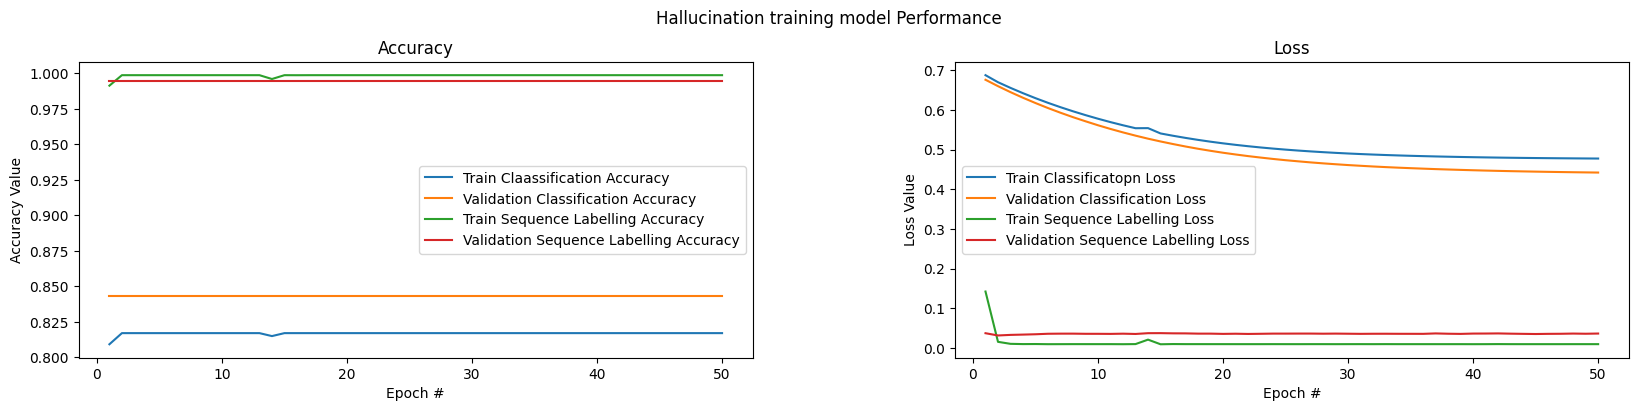

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Hallucination training model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

EPOCHS = 50

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['dense_2_f1_score'], label='Train Claassification Accuracy')
ax1.plot(epoch_list, history.history['val_dense_2_f1_score'], label='Validation Classification Accuracy')
ax1.plot(epoch_list, history.history['time_distributed_1_f1_score'], label='Train Sequence Labelling Accuracy')
ax1.plot(epoch_list, history.history['val_time_distributed_1_f1_score'], label='Validation Sequence Labelling Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['dense_2_loss'], label='Train Classificatopn Loss')
ax2.plot(epoch_list, history.history['val_dense_2_loss'], label='Validation Classification Loss')
ax2.plot(epoch_list, history.history['time_distributed_1_loss'], label='Train Sequence Labelling Loss')
ax2.plot(epoch_list, history.history['val_time_distributed_1_loss'], label='Validation Sequence Labelling Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

**Model evaluation**

In [22]:
load_model = tf.keras.models.load_model("./best_model_checkpoint.h5",
                                        custom_objects={'TFBertModel': TFBertModel,
                                                        'F1Score': F1Score()})

In [23]:
x_test = (test_encoded_query['input_ids'], test_encoded_query['attention_mask'], 
                             test_encoded_responses['input_ids'], test_encoded_responses['attention_mask'])
y_test = (test_binary_labels_tensor, test_bio_tags_tensor)
load_model.evaluate(x_test, y_test, batch_size=8)

189/189 [==============================] - 82s 397ms/step - loss: 0.4983 - dense_2_loss: 0.4834 - time_distributed_1_loss: 0.0149 - dense_2_f1_score: 0.8129 - time_distributed_1_f1_score: 0.9980


[0.4983217418193817,
 0.4834461808204651,
 0.014875788241624832,
 0.8128731846809387,
 0.998009204864502]

In [26]:
# Define maximum sequence length for BERT input
max_length = 500

def try_encoding(data, max_length):
    # Tokenize and encode the User Query
    encoded_query = tokenizer.batch_encode_plus(
        data[0],
        add_special_tokens=True,  # '[CLS]' token will be added automatically
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

    # Tokenize and encode the chatgpt_responses
    encoded_responses = tokenizer.batch_encode_plus(
        data[1],
        add_special_tokens=True,  # '[CLS]' token will be added automatically
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encoded_query, encoded_responses

# def try_id_mask(encoded_query, encoded_responses):
#     query_input_ids = encoded_query['input_ids']
#     query_attention_masks = encoded_query['attention_mask']

#     responses_input_ids = encoded_responses['input_ids']
#     response_attention_masks = encoded_responses['attention_mask']

#     return query_input_ids, query_attention_masks, responses_input_ids, response_attention_masks

In [27]:
# us_q = "What is YOLOv7?"
# gpt_q = "As of my last knowledge update in January 2022, YOLOv7 (You Only Look Once version 7) did not exist. The YOLO (You Only Look Once) series is a family of real-time object detection algorithms that process images in a single forward pass through the neural network, making them efficient for real-time applications.\nThe YOLO algorithm has gone through several versions, starting with YOLOv1 and progressing through YOLOv2 (also known as YOLO9000), YOLOv3, and YOLOv4. Each version brought improvements in terms of accuracy, speed, and the ability to detect a wider range of objects.\nIf YOLOv7 has been released or developed after my last update in January 2022, I recommend checking the official publications, research papers, or the official repository of the YOLO project for the most up-to-date information. The official repository is typically hosted on platforms like GitHub."



us_q = "It changes the fractional values. For example, array([[0.8155323 , 0.19134651]], dtype=float32). Here 0.8155 is the most precious value, near to 1. It can be accepted. How can I retrieve this?"
gpt_q = "If you have a one-hot encoded array with fractional values and you want to retrieve the original labels based on the maximum probability, you can use np.argmax as previously mentioned. However, in your case, it seems like you have probabilities rather than strict 0s and 1s. If you want to round the probabilities to the nearest integer (considering them as probabilities of class 1), you can use np.round before applying np.argmax. Here's how you can do it:"


data = [[us_q], [gpt_q]]

try_enc_q, try_enc_res = try_encoding(data, max_length)
# try_encoded_query, =try_id_mask(try_enc_q, try_enc_res)

x = (try_enc_q['input_ids'], try_enc_q['attention_mask'], 
                             try_enc_res['input_ids'], try_enc_res['attention_mask'])


# Define a custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        # self.f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        self.f1_score.assign(2 * tf.divide(tf.multiply(precision, recall), tf.add(precision, recall) + tf.keras.backend.epsilon()))
        return self.f1_score

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0.0)
        
load_model = tf.keras.models.load_model("./best_model_checkpoint.h5",
                                        custom_objects={'TFBertModel': TFBertModel,
                                                        'F1Score': F1Score()})

cls, span = load_model.predict(x)

1/1 [==============================] - 7s 7s/step


In [28]:
round_cls = np.round(cls)
retrieved_labels = np.argmin(round_cls, axis=1)
print(retrieved_labels[0])

1


In [29]:
for i in range(span[0].shape[0]):
    print(span[0][i])

[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842376e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842376e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.9911314e-01 1.3541390e-10 1.0415031e-10 8.8684197e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.9911314e-01 1.3541390e-10 1.0415031e-10 8.8684197e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842841e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842376e-04]
[9.9911314e-01 1.3541390e-10 1.0415031e-10 8.8684150e-04]
[9.99113142e-01 1.35414416e-10 1.04150716e-10 8.86842376e-04]
[9.9911314e-01 1.354

In [67]:
np.argmin(span, axis=-1)

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [26]:
max_indices = np.argmin(span, axis=-1)  # This will give you an array of indices

# Step 2: Map indices to class labels
index_to_label = {0: 'O', 1: 'B', 2: 'I', 3: 'INC'}  # Map according to your specific classes
predicted_labels = [[index_to_label[idx] for idx in sequence] for sequence in max_indices]

print(len(predicted_labels[0]))

64


# Modifying the Model Network

**New Model design**

In [19]:
# Define model inputs for queries and responses
query_input_ids = Input(shape=(max_length,), dtype='int32', name='query_input_ids')
query_attention_mask = Input(shape=(max_length,), dtype='int32', name='query_attention_mask')

response_input_ids = Input(shape=(max_length,), dtype='int32', name='response_input_ids')
response_attention_mask = Input(shape=(max_length,), dtype='int32', name='response_attention_mask')

# BERT embeddings for queries and responses
query_bert_output = bert_model(query_input_ids, attention_mask=query_attention_mask)[0]
response_bert_output = bert_model(response_input_ids, attention_mask=response_attention_mask)[0]

# Process each stream with additional layers
query_processed = GlobalAveragePooling1D()(query_bert_output)
response_processed = GlobalAveragePooling1D()(response_bert_output)

# Combine processed outputs
combined_output = Concatenate()([query_processed, response_processed])

# Dense layers for binary classification
classification_dense_1 = Dense(4, activation='relu', name='Class_Dense_Layer_1')(combined_output)
classification_dense_2 = Dense(64, activation='relu', name='Class_Dense_Layer_2')(classification_dense_1)
classification_dropout_1 = Dropout(0.5, name="DropOUT_Class_1")(classification_dense_2)
classification_dense_3 = Dense(64, activation='relu', name='Class_Dense_Layer_3')(classification_dropout_1)
classification_dropout_2 = Dropout(0.5, name="DropOUT_Class_2")(classification_dense_3)
classification_output = Dense(2, activation='sigmoid')(classification_dropout_2)

# Sequence labeling branch for response
labeling_dense = Dense(8, activation='relu', name='Label_Dense_Layer_1')(response_bert_output)
labeling_output = TimeDistributed(Dense(4, activation='softmax'))(labeling_dense)

tf.keras.backend.clear_session()    # Clear Session if there any active session exists.

# Define the ModelCheckpoint callback
checkpoint_path = "./New_best_model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # 'min' means save the model when the monitored quantity (val_loss) has stopped decreasing
    verbose=1  # 1: display messages, 0: silent
)

# Define a custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        # self.f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        self.f1_score.assign(2 * tf.divide(tf.multiply(precision, recall), tf.add(precision, recall) + tf.keras.backend.epsilon()))
        return self.f1_score

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0.0)

# Build the model
dual_input_model = Model(
    inputs=[query_input_ids, query_attention_mask, response_input_ids, response_attention_mask],
    outputs=[classification_output, labeling_output]
)
dual_input_model.compile(optimizer=Adam(learning_rate=0.0001), 
                         loss=['binary_crossentropy', 'categorical_crossentropy'],
                         metrics=[F1Score()])

# Model summary
dual_input_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 query_input_ids (InputLayer)   [(None, 64)]         0           []                               
                                                                                                  
 query_attention_mask (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 response_input_ids (InputLayer  [(None, 64)]        0           []                               
 )                                                                                                
                                                                                              

In [95]:
history_2 = dual_input_model.fit(
    [train_encoded_query['input_ids'], train_encoded_query['attention_mask'], 
     train_encoded_responses['input_ids'], train_encoded_responses['attention_mask']],
    [train_binary_labels_tensor, train_bio_tags_tensor],
    batch_size=8,
    epochs=100,
    validation_data = ([valid_encoded_query['input_ids'], valid_encoded_query['attention_mask'], 
     valid_encoded_responses['input_ids'], valid_encoded_responses['attention_mask']],
    [valid_binary_labels_tensor, valid_bio_tags_tensor],),
    # steps_per_epoch = 20,
    callbacks = [checkpoint_callback]
)

Epoch 1/100
350/350 [==============================] - ETA: 0s - loss: 1.2497 - dense_loss: 0.5841 - time_distributed_loss: 0.6656 - dense_f1_score: 0.8012 - time_distributed_f1_score: 0.7430

C:\Users\ky\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2086: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_loss improved from inf to 0.60327, saving model to .\New_best_model_checkpoint.h5
350/350 [==============================] - 116s 289ms/step - loss: 1.2497 - dense_loss: 0.5841 - time_distributed_loss: 0.6656 - dense_f1_score: 0.8012 - time_distributed_f1_score: 0.7430 - val_loss: 0.6033 - val_dense_loss: 0.4563 - val_time_distributed_loss: 0.1470 - val_dense_f1_score: 0.8300 - val_time_distributed_f1_score: 0.9850
Epoch 2/100
350/350 [==============================] - ETA: 0s - loss: 0.6928 - dense_loss: 0.4994 - time_distributed_loss: 0.1934 - dense_f1_score: 0.8180 - time_distributed_f1_score: 0.9601
Epoch 2: val_loss improved from 0.60327 to 0.56724, saving model to .\New_best_model_checkpoint.h5
350/350 [==============================] - 97s 278ms/step - loss: 0.6928 - dense_loss: 0.4994 - time_distributed_loss: 0.1934 - dense_f1_score: 0.8180 - time_distributed_f1_score: 0.9601 - val_loss: 0.5672 - val_dense_loss: 0.4563 - val_time_distributed_loss: 0.1110 - val_den

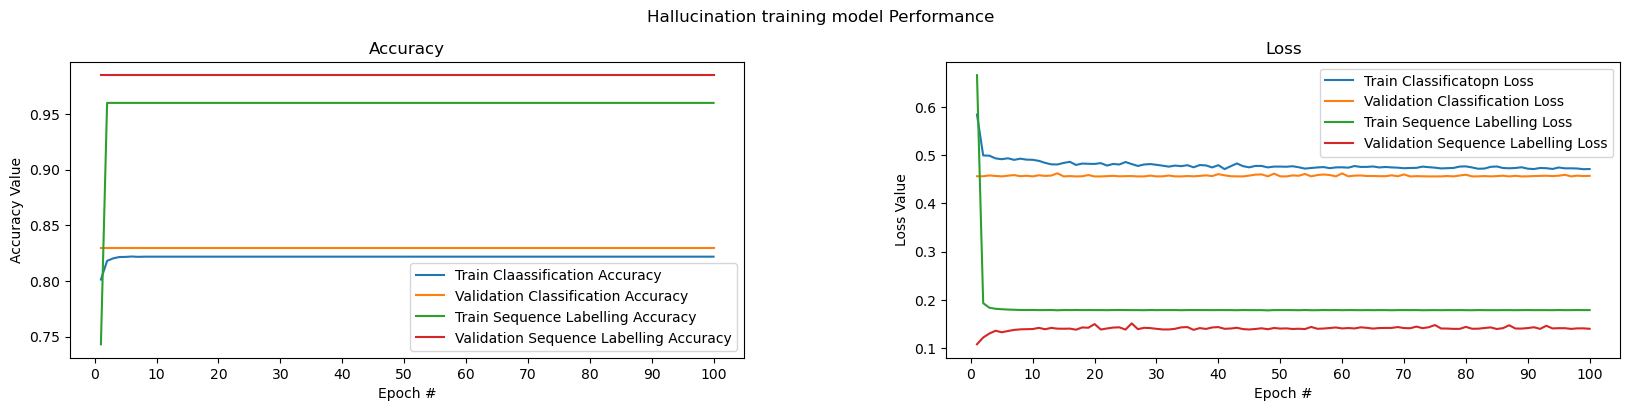

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Hallucination training model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

EPOCHS = 100

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history_2.history['dense_f1_score'], label='Train Claassification Accuracy')
ax1.plot(epoch_list, history_2.history['val_dense_f1_score'], label='Validation Classification Accuracy')
ax1.plot(epoch_list, history_2.history['time_distributed_f1_score'], label='Train Sequence Labelling Accuracy')
ax1.plot(epoch_list, history_2.history['val_time_distributed_f1_score'], label='Validation Sequence Labelling Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_2.history['dense_loss'], label='Train Classificatopn Loss')
ax2.plot(epoch_list, history_2.history['val_dense_loss'], label='Validation Classification Loss')
ax2.plot(epoch_list, history_2.history['time_distributed_loss'], label='Train Sequence Labelling Loss')
ax2.plot(epoch_list, history.history['val_time_distributed_loss'], label='Validation Sequence Labelling Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [21]:
load_model = tf.keras.models.load_model("./modified_best_model_checkpoint.h5",
                                        custom_objects={'TFBertModel': TFBertModel,
                                                        'F1Score': F1Score()})

In [22]:
x_test = (test_encoded_query['input_ids'], test_encoded_query['attention_mask'], 
                             test_encoded_responses['input_ids'], test_encoded_responses['attention_mask'])
y_test = (test_binary_labels_tensor, test_bio_tags_tensor)
load_model.evaluate(x_test, y_test, batch_size=8)

189/189 [==============================] - 94s 456ms/step - loss: 0.5303 - dense_loss: 0.4822 - time_distributed_loss: 0.0481 - dense_f1_score: 0.8129 - time_distributed_f1_score: 0.9980


[0.5302802920341492,
 0.48216912150382996,
 0.04811115562915802,
 0.8128731846809387,
 0.998009204864502]